In [10]:
# -*- coding: utf-8 -*-
%matplotlib notebook

"""
Version: 09.02.2019
@author: Markus Dittmer [m_ditt05@uni-muenster.de]
"""

import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.ticker as ticker

import scipy
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy.signal import savgol_filter

import datetime
import time as tm

from tabulate import tabulate
from astropy.stats import histogram
import re
import random

from uncertainties import ufloat
from uncertainties.umath import *
import uncertainties.unumpy as unp


def nearest_interp(xi, x, y):
    idx = np.abs(x - xi[:,None])
    return y[idx.argmin(axis=1)]

#%matplotlib inline








#timestamp
now = datetime.datetime.now()        
timestamp = now.isoformat()

###Global stuff
debugging = False
elCh =  1.602176620898*10**(-19) 
SPINE_COLOR = "grey"
color_Arctic='#AEC7E8'
color_Nectarine='#FFBB78'
color_Dark_Blue='#1F77B4'

#use tab:red for tableau colors...other tab colors (20 in total):
tab20_colors=['#9edae5','#17becf','#dbdb8d','#bcbd22','#c7c7c7','#7f7f7f','#f7b6d2','#e377c2','#c49c94','#8c564b','#c5b0d5','#9467bd','#ff9896','#d62728','#98df8a','#2ca02c','#ffbb78','#ff7f0e','#aec7e8','#1f77b4']

def latexify(fig_width=None, ratio = (math.sqrt(5)-1.0)/2.0 ,fig_height=None):
    fig_width_pt = 455.24413     # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.0#.27  # Convert pt to inch

    if fig_width is None:
        fig_width = fig_width_pt*inches_per_pt
    elif fig_width is not None:
        fig_width = fig_width_pt*inches_per_pt*fig_width
    elif fig_height is None:
        fig_width = fig_width*fig_width_pt*inches_per_pt

    if fig_height is None:
        #golden_mean = 0.8
        golden_mean = ratio# Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 10.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
                 "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES
    matplotlib.rc('axes',edgecolor="#595959")
    params = {
          'backend': 'ps',
          #'text.latex.preamble': ['\usepackage{gensymb}'],
          'axes.labelsize': 10, # fontsize for x and y labels (was 10)
          'axes.titlesize': 11,
          'font.size':       10, # was 10
          'legend.fontsize': 10, # was 10
          'xtick.labelsize': 9,
          'ytick.labelsize': 9,
          'text.usetex': True,
          'pgf.texsystem': "pdflatex",
          'figure.figsize': [fig_width,fig_height],
          'font.family': "serif",
          'font.serif': ['Computer Modern Roman'],  # blank entries should cause plots to inherit fonts from the document
          'font.sans-serif': ['Computer Modern Sans serif']
        }
        
    matplotlib.rcParams.update(params)

    

def makeaplot(logscale = False ,grid = True, axisoff = False,xlim=[0,0],ylim=[0,0],xlabel='a',ylabel='a'):
    global ax
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    plt.rc('text',usetex='True')
    plt.rc('axes',edgecolor="#595959")
    ax.spines["bottom"].set_color(SPINE_COLOR)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["left"].set_color(SPINE_COLOR)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["right"].set_color(SPINE_COLOR)
    ax.spines["right"].set_linewidth(0.5)
    ax.spines["top"].set_color(SPINE_COLOR)
    ax.spines["top"].set_linewidth(0.5)
    
    
    
    params = {
          #'backend': 'ps',
          'text.latex.preamble': [r'\usepackage{gensymb}'],
          'text.usetex': True,
          'pgf.texsystem': "pdflatex",
          'font.family': "serif",
          'font.serif': ['Computer Modern Roman'], 
          'font.sans-serif': ['Computer Modern Sans serif']
        }
        
    matplotlib.rcParams.update(params)


    if logscale:
        plt.yscale('log', nonposy='clip')
    if grid:
        plt.grid(color = "#595959", linestyle='dotted', lw = 0.8, alpha = 0.5)
        plt.rc('axes', axisbelow=True)#xy
    if axisoff:
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
    if xlim != [0,0]:
        plt.xlim(xlim[0],xlim[1])
    if ylim != [0,0]:
        plt.ylim(ylim[0],ylim[1])
    if xlabel != 'a':
        plt.xlabel(xlabel)
    if ylabel != 'a':
        plt.ylabel(ylabel)

        
      
        
def finishplot(legend = True,legendabove=False,filename = 'a',secondaxis=[0,0,'0',False]):
    if legend:
        plt.legend(framealpha=1,loc=0,ncol=1,fancybox=True)
    if legendabove:
        plt.legend(bbox_to_anchor=(0,1.001,1,0.2), loc="lower left",    mode="expand", borderaxespad=0, ncol=3)
        
    if secondaxis != [0,0,'0',False]:
        
        ax2 = ax.twiny()
        x_ax2_min = secondaxis[0]
        x_ax2_max = secondaxis[1]
        ax2.set_xlim(x_ax2_min,x_ax2_max) #hier die Ticks!
        ax2.xaxis.set_ticks_position("bottom") #runter damit
        ax2.xaxis.set_label_position("bottom") #runter damit
        ax2.spines["bottom"].set_position(("axes", -0.195)) #offset nach unten
        ax2.spines["bottom"].set_color(SPINE_COLOR)
        ax2.spines["bottom"].set_linewidth(0.5)
        ax2.set_frame_on(True)
        ax2.patch.set_visible(False)
        for sp in ax2.spines.itervalues():
            sp.set_visible(False)
        ax2.spines["bottom"].set_visible(True)
        ax2.set_xlabel(secondaxis[2])
        
        if secondaxis[3]:
            ax2.set_xscale('log')    
    plt.tight_layout()
    if filename != 'a':
        plt.savefig('{}.pdf'.format(filename), dpi = 1000, bbox_inches='tight')
    plt.show()
 


def Gaussian(x,height,mean,sigma):
    return height*np.exp(- (x-mean)**2 / (2*sigma**2))



'''
"""Fitting"""
Initial = [float(50), float(15), float(20)]
popt, pcov = curve_fit(Gaussian, x, y, p0 = Initial)
error = np.sqrt(np.diag(pcov))  #array!

fitx = np.linspace(np.amin(x),np.amax(x),np.size(x)*100)
cond = np.logical_and(True,True)

plt.fill_between(x,y1=Gaussian(x,*popt-error),y2=Gaussian(x,*popt+error),color='black')


"""Readin Interpolation Output"""
#hersteller
wave, eff = np.loadtxt('Hersteller.csv',usecols=(0,1),unpack=True)
inter = interpolate.interp1d(wave, eff,kind='cubic')
xnew = np.arange(min(wave), max(wave), 0.1)
ynew = inter(xnew)    

#get output file for later calculations
stepsize = [5,10,25,50]
for step in stepsize:
    labwaves = np.linspace(200,750,(750.-200.)/step+1)
    Labefficiency = nearest_interp(labwaves, xnew,ynew)
    np.savetxt('Grating_efficiency_%inm_steps.txt' %(step), np.transpose([labwaves,Labefficiency]),delimiter='\t',fmt='%1.4f') 
    
#smooth interpolation
#yhat = savgol_filter(ynew, 51, 4) #<point and nr polynoms (<1st thing)


"""ufloat"""
meanerrordelta = []
for i in range(0,len(rates_down)):
    x = ufloat(rates_down[i], rates_e_down[i])
    y = ufloat(rates_up[i], rates_e_up[i])
    errmean = (x+y)/2.
    #print(unp.nominal_values(errmean))
    meanerrordelta.append(float(unp.std_devs(errmean)))


"""Chi squared"""


'''


print('Ready')

Ready


# Get temperature factors

In Martin's PhD thesis he assumed a constanct yield factor of 1.7 (electron  = 1.7 * alpha). However, this factor changes with temperature. A quick solution is to linear fit this factor (measured in Markus' Master thesis) and exchange the Vitrovex scintillation file.
The original scintillation file (alpha yield pre PMT simulation changes) is stored in G4Files/Scint_Vitrovex

<IPython.core.display.Javascript object>


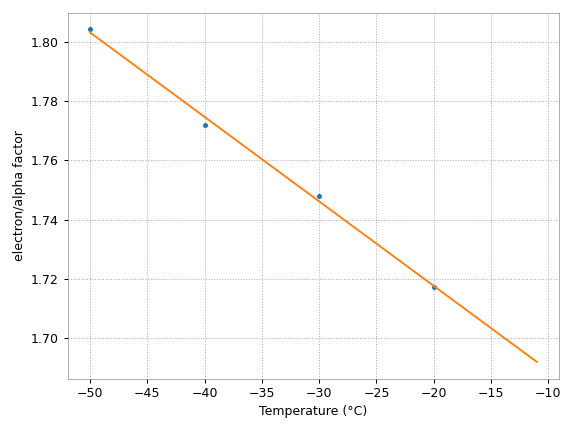

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Computer Modern Sans serif


[-0.00286023  1.66032307]


In [2]:
alpha = np.loadtxt("MasterThesisResults/Alpha/AlphaYield2018Batch.txt", unpack=1)
electron = np.loadtxt("MasterThesisResults/Electron/ElectronYield2018Batch.txt", unpack=1)

def fitfkt(x,m,c):
    return m*x+c

temp = alpha[0]
factor = electron[1]/alpha[1]

popt, pcov = curve_fit(fitfkt, temp, factor)#, p0 = Initial)
error = np.sqrt(np.diag(pcov))  #array!
xfit=np.arange(-50,-10,1)




makeaplot(xlabel="Temperature (°C)",ylabel="electron/alpha factor")
#plt.errorbar(alpha[0],alpha[1],yerr=(alpha[2],alpha[3]))
#plt.errorbar(electron[0],electron[1],yerr=(electron[2],electron[3]))

plt.plot(alpha[0],electron[1]/alpha[1],'.')
plt.plot(xfit,fitfkt(xfit,*popt))
finishplot(legend=False)

#for t,f in zip(alpha[0],electron[1]/alpha[1]):
#    print(t, f)

print(popt)
fit_elec = popt

This "electron factor" does need to be changed since a change in PMT efficiency from the simulation should scale both alpha and electron yield in the same manner.

It should in principle only be implemented once and be set (until remeasured)

# Match these simulated PMT rates when it worked

Figure 11.35 from https://www.uni-muenster.de/imperia/md/content/physik_kp/agkappes/abschlussarbeiten/doktorarbeiten/phd_thesis_unland.pdf. This is the simulated PMT rate based on our scintillation measurements BEFORE the new PMT simulation (which changed the efficiency). Recreate this with a scaling factor for the measured Vitrovex alpha vield to go back to normal.

In [4]:
ExpectedPMTRate_0ns = np.array([324.77, 386.19, 449.95, 513.99,  589.06, 632.75])
ExpectedPMTRate_80ns = np.array([280.55, 334.68, 389.33, 445.43, 509.94, 551.77])
ExpectedPMTRate_0ns = ExpectedPMTRate_0ns[::-1] 
ExpectedPMTRate_80ns = ExpectedPMTRate_80ns[::-1] 

<IPython.core.display.Javascript object>


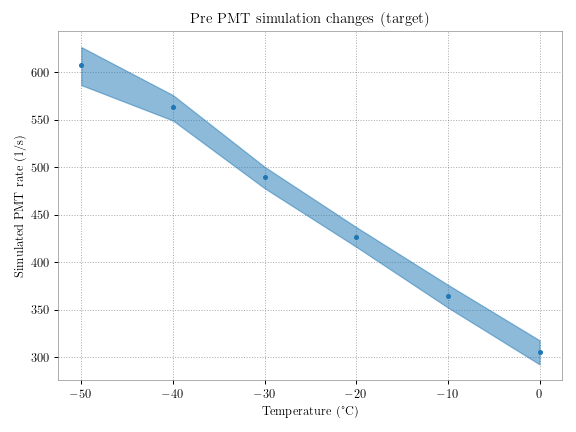

In [3]:
#Was from Plot2Data -> exchange with accurate real data
ExpectedTemps = np.array([-50, -40, -30, -20, -10, 0])
ExpectedPMTRate_10ns = np.array([607.361963190184, 563.1901840490798, 490.03067484662574, 426.99386503067484, 364.4171779141104, 305.52147239263803])
ExpectedPMTRate_10ns = np.round(ExpectedPMTRate_10ns,2)

ExpectedPMTRate_10ns_l = np.array([    292.63803680981596,    352.4539877300613,    416.41104294478527,    478.0674846625767,    549.3865030674847,    586.6564417177915])
ExpectedPMTRate_10ns_l = np.round(ExpectedPMTRate_10ns_l[::-1],2)

ExpectedPMTRate_10ns_u = np.array([    626.6871165644172,    576.0736196319019,    500.6134969325153,    437.1165644171779,    376.3803680981595,    317.9447852760736])
ExpectedPMTRate_10ns_u = np.round(ExpectedPMTRate_10ns_u,2)

makeaplot(xlabel="Temperature (°C)",ylabel="Simulated PMT rate (1/s)")
plt.title("Pre PMT simulation changes (target)")
plt.plot(ExpectedTemps,ExpectedPMTRate_10ns,'.',color='tab:blue')
plt.fill_between(ExpectedTemps,y1=ExpectedPMTRate_10ns_u,y2=ExpectedPMTRate_10ns_l,color='tab:blue',alpha=0.5)
finishplot(legend=False)

#makeaplot(xlabel="Temperature (°C)",ylabel="Rate - Uncertainty (1/s)")
#plt.plot(ExpectedTemps,ExpectedPMTRate_10ns-ExpectedPMTRate_10ns_u,'.',color='tab:blue',label='upper uncertainty')
#plt.plot(ExpectedTemps,ExpectedPMTRate_10ns_l-ExpectedPMTRate_10ns,'.',color='tab:red',label='lower uncertainty')
#finishplot(legend=False)

ExpectedPMTRate_10ns_e = abs(np.mean([ExpectedPMTRate_10ns-ExpectedPMTRate_10ns_l,ExpectedPMTRate_10ns_u-ExpectedPMTRate_10ns],axis=0))

# Calculate simulated rates

Now simulate for different alpha yields (electron yield is scaled ~1.7 to alphas - see above). Calculate the simulated PMT rate for different alpha yields for a given temperature and compare to the expected rate (match Martins simulation data from above for 10ns deadtime). That alpha yield shall be the one that corresponds to the correct one, after factoring in the efficiency changes since the PMT simulation changed. (The yield determination uses the mDOM PMT simulation. If that changes, the yield changes accordingly)

create a .sh file like this and run it

#!/bin/bash

temperatures=(0 -10 -20 -30 -40 -50)

for temp in "${temperatures[@]}"; do
    ./OMSim_radioactive_decays --no_PMT_decays --efficiency_cut -n 1 --time_window 20 --temperature $temp -o "FinalCheck_mDOM_20sWindow_${temp}C" --environment 1 --threads 3
done


In [4]:
import json
def gimme(deadtime=10e-9,printline=False):

    
    hits=[]
    deadhits=[]
    alldts=[]
    
    total=[]
    lost=[]
    skipped=False

    #plt.figure()
    for p in range(0,int(max(PMT)+1)):
        thistime=time[PMT==p]
        thisdp=DP[PMT==p]
        thisdts=[]

        sortedtime = np.sort(thistime)
        uniquetimes = np.unique(sortedtime)
        if printline:
            print(f"Lost {len(sortedtime)-len(uniquetimes)}/{len(sortedtime)} due to same time")
        lost.append(len(sortedtime)-len(uniquetimes))
        total.append(len(sortedtime))
        sortedtime = uniquetimes
        
        dt=[]
        de=[]
        outsort=[]
        for i in range(1,len(sortedtime)):
            if skipped:
                currentdt = sortedtime[i]-skippedtime
            else:
                currentdt = sortedtime[i]-sortedtime[i-1]
            thisdts.append(currentdt)

            #deadtime sorter:
            if currentdt<deadtime:
                outsort.append(thisdp[i])
                skipped=True
                skippedtime=sortedtime[i-1]
                #print(currentdt)
                continue
            dt.append(currentdt)
            de.append(thisdp[i])
            skipped=False

        #plt.hist(dt)
        hits.append(sum(de)/duration)
        deadhits.append(sum(outsort)/duration)
        alldts.append(thisdts)
    return hits,deadhits, deadtime, alldts, np.mean(lost), np.mean(total)

def linfit(x,m,c):
    return m*x + c

T=-50 Alphayield=160:	 Average PMT rate: 556.10 +- 11.95	 Target: 607.36
T=-50 Alphayield=170:	 Average PMT rate: 600.30 +- 18.98	 Target: 607.36
T=-50 Alphayield=180:	 Average PMT rate: 636.16 +- 12.32	 Target: 607.36
T=-50 Alphayield=190:	 Average PMT rate: 674.92 +- 19.16	 Target: 607.36
T=-50 Alphayield=200:	 Average PMT rate: 707.28 +- 18.40	 Target: 607.36


<IPython.core.display.Javascript object>


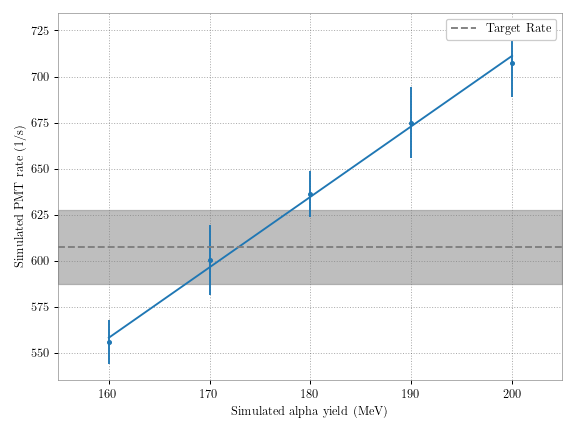

T=-50: Target alpha yield: 173+/-32
T=-40 Alphayield=140:	 Average PMT rate: 491.61 +- 14.53	 Target: 563.19
T=-40 Alphayield=160:	 Average PMT rate: 556.50 +- 18.06	 Target: 563.19
T=-40 Alphayield=170:	 Average PMT rate: 605.41 +- 18.03	 Target: 563.19
T=-40 Alphayield=180:	 Average PMT rate: 624.13 +- 17.87	 Target: 563.19


<IPython.core.display.Javascript object>


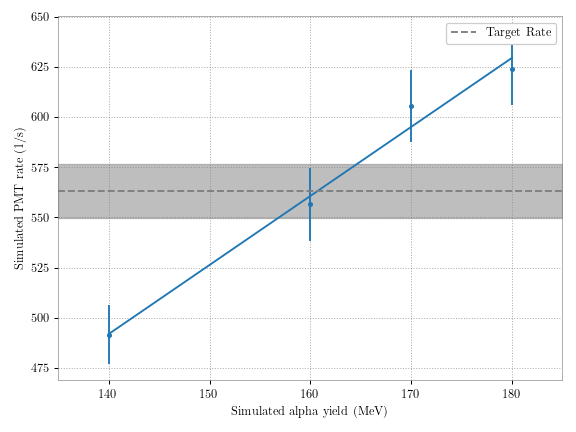

T=-40: Target alpha yield: (1.6+/-0.4)e+02
T=-30 Alphayield=130:	 Average PMT rate: 464.56 +- 10.83	 Target: 490.03
T=-30 Alphayield=140:	 Average PMT rate: 486.70 +- 14.40	 Target: 490.03
T=-30 Alphayield=150:	 Average PMT rate: 516.40 +- 18.81	 Target: 490.03


<IPython.core.display.Javascript object>


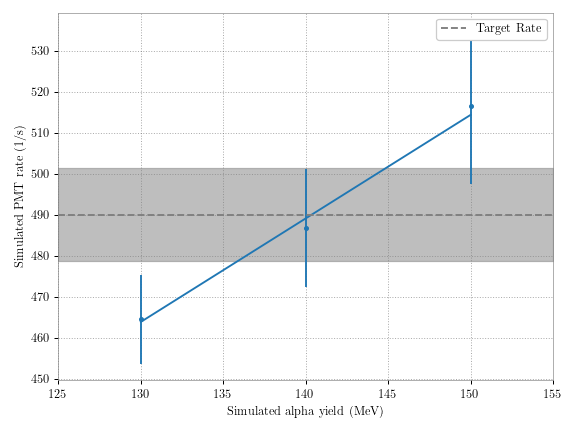

T=-30: Target alpha yield: (1.4+/-0.8)e+02
T=-20 Alphayield=110:	 Average PMT rate: 389.57 +- 9.48	 Target: 426.99
T=-20 Alphayield=120:	 Average PMT rate: 424.04 +- 11.13	 Target: 426.99
T=-20 Alphayield=130:	 Average PMT rate: 462.01 +- 11.75	 Target: 426.99


<IPython.core.display.Javascript object>


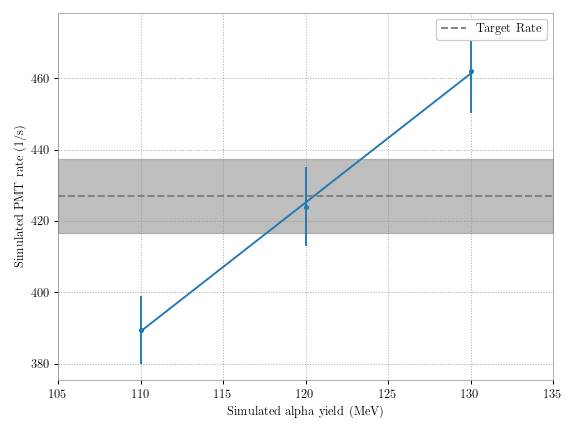

T=-20: Target alpha yield: 120+/-35
T=-10 Alphayield=90:	 Average PMT rate: 313.80 +- 12.30	 Target: 364.42
T=-10 Alphayield=100:	 Average PMT rate: 357.80 +- 12.88	 Target: 364.42
T=-10 Alphayield=110:	 Average PMT rate: 381.24 +- 11.72	 Target: 364.42


<IPython.core.display.Javascript object>


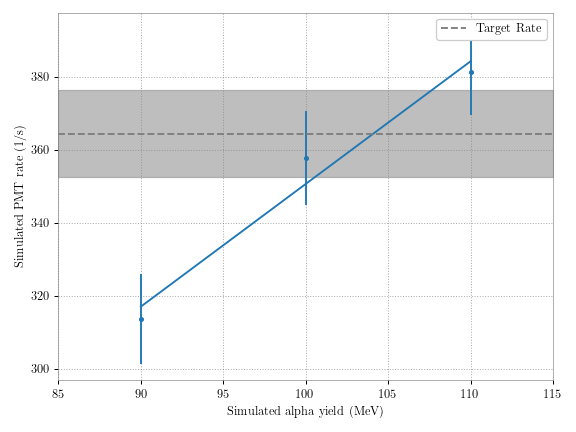

T=-10: Target alpha yield: (1.0+/-0.4)e+02


In [37]:
folder = 'data2/'
simtemps = np.arange(-50, -9, 10)
testalphayields = np.arange(0,300,10)

jYieldAlpha = []
jYieldAlphaTemperature = []
for temp in simtemps:
    simrates=[]
    simrates_e=[]
    
    
    alphayields=[]
    for alpha in testalphayields:
        filename = f"{folder}DetailedScalingVitrovexYields_{temp}_{alpha}"
        
        try:
            settingsfile = f"{filename}_args.json"
            # Load JSON data directly from file
            with open(settingsfile, 'r') as file:
                data = json.load(file)

            num_events = data['numevents']
            time_window = data['time_window']
            duration=num_events*time_window

            eventid, time, PMT, energy, x, y, z, PE, TT, DP = np.genfromtxt(f"{filename}_hits.dat",unpack=1)#, dtype=np.longdouble)

            hits, deadhits, deadtime, alldts, lost, total = gimme(deadtime=10e-9)
            print(f'T={temp} Alphayield={alpha}:\t Average PMT rate: {np.mean(hits):.2f} +- {np.std(hits):.2f}\t Target: {ExpectedPMTRate_10ns[ExpectedTemps==temp][0]}')#"  Eaten by deadtime ({deadtime*10**9}ns): {sum(deadhits)/(sum(hits)+sum(deadhits))*100:.2f}%')
            simrates.append(np.mean(hits))
            simrates_e.append(np.std(hits))
            alphayields.append(alpha)
        except:
            continue

    alphayields=np.array(alphayields)
    TargetRate = ufloat(ExpectedPMTRate_10ns[ExpectedTemps==temp][0], ExpectedPMTRate_10ns_e[ExpectedTemps==temp][0])
    
    popt, pcov = curve_fit(linfit, alphayields, simrates, sigma=simrates_e, absolute_sigma=True)
    error = np.sqrt(np.diag(pcov))  
    
    makeaplot(xlabel='Simulated alpha yield (MeV)',ylabel='Simulated PMT rate (1/s)',xlim=(min(alphayields)-5,max(alphayields)+5))
    plt.errorbar(alphayields,simrates,simrates_e,fmt='.',color='tab:blue')
    plt.plot(alphayields,linfit(alphayields,*popt),color='tab:blue')
    plt.axhline(TargetRate.nominal_value,label='Target Rate',color='tab:gray',ls='--')
    plt.fill_between(np.linspace(min(alphayields)-5,max(alphayields)+5,len(ExpectedTemps)),y1 = TargetRate.nominal_value-TargetRate.std_dev, y2=TargetRate.nominal_value+TargetRate.std_dev,color='tab:gray',alpha=0.5)
    finishplot()
    
    
    target_yield = (TargetRate - ufloat(popt[1],error[1])) / ufloat(popt[0],error[0])
    print(f"T={temp}: Target alpha yield: {target_yield}")
    jYieldAlpha.append(target_yield.nominal_value)
    jYieldAlphaTemperature.append(temp)

jYieldAlphaTemperature=np.array(jYieldAlphaTemperature)
jYieldAlpha=np.array(jYieldAlpha)


# Calculate efficiency factor correction

Since the PMT simulation was changed and might change again in the future, I decided to not change the alpha and electron yields in the json files but introduce a correction factor. Then this scaling can be repeated and just the number has to be changed. Otherwise the 'correct' alpha yield might be lost at some point. The electron yield factor stays the same for the respective glass!

<IPython.core.display.Javascript object>


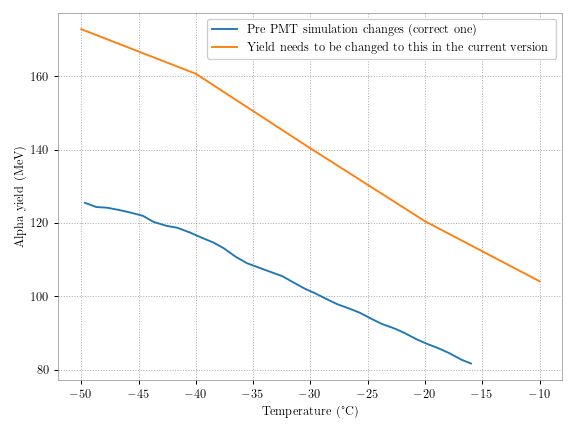

<IPython.core.display.Javascript object>


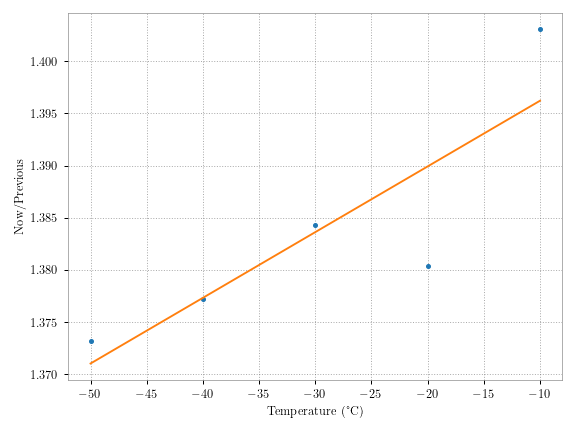

[6.29566414e-04 1.40251849e+00]
This is your correction factor: 0.0006295664136832801 * temperature + 1.402518494853111


In [38]:
with open("G4Files/Scint_Vitrovex.dat", 'r') as file:
    preyields = json.load(file)
    
pret = preyields['jYieldAlphaTemperature']
prey = preyields['jYieldAlpha']

nowt = jYieldAlphaTemperature
nowy = jYieldAlpha

makeaplot(xlabel='Temperature (°C)',ylabel='Alpha yield (MeV)')
plt.plot(pret,prey,label='Pre PMT simulation changes (correct one)')
plt.plot(nowt, nowy,label='Yield needs to be changed to this in the current version')
finishplot()


#Factor between those
interpolator = interp1d(pret, prey, kind='linear', fill_value='extrapolate')
interpolated_prey = interpolator(nowt)
factor = nowy / interpolated_prey

#print("Interpolated Prey:", interpolated_prey)
#print("Factor (Now/Previous):", factor)


makeaplot(xlabel='Temperature (°C)',ylabel='Now/Previous')
plt.plot(nowt,factor,'.')

xfit=np.arange(-50,-9,1)
popt, pcov = curve_fit(fitfkt, nowt, factor)#, p0 = Initial)
error = np.sqrt(np.diag(pcov)) 
print(popt)
plt.plot(xfit,fitfkt(xfit,*popt))

popt_PMTcorr = popt

finishplot(legend=False)

print(f"This is your correction factor: {popt[0]} * temperature + {popt[1]}")

# Check after changing the factors in OMSim

Rerun the same .sh file after implementing the correction factor from above

## Compared to previous simulation

In [5]:
from matplotlib.gridspec import GridSpec

def plotit(Expected, Simulated, SimulatedTemps, deadtime):

    # Set up a gridspec with uneven row heights
    fig = plt.figure(figsize=(5, 4))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0)  # Set horizontal space to 0

    # Create subplots
    ax = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax)

    # Main plot on ax
    ax.set_title(f"{deadtime}ns deadtime")
    ax.plot(ExpectedTemps, Expected, '.', color='tab:blue', label='Correct (pre PMT simulation changes)')
    ax.plot(SimulatedTemps, Simulated, '.', color='tab:red', label='Current simulation output')
    ax.set_ylabel('Simulated PMT rate (1/s)')
    ax.legend()
    #ax.set_ylim(0, 700)  # Customize based on your data range

    # Turn off x-axis labels and tick marks for the top subplot
    ax.tick_params(axis='x',          # Changes apply to the x-axis
                   which='both',      # Both major and minor ticks are affected
                   bottom=False,      # Ticks along the bottom edge are off
                   top=False,         # Ticks along the top edge are off
                   labelbottom=False) # Labels along the bottom edge are off

    # Residuals plot on ax2
    mask = np.nonzero(np.isin(ExpectedTemps, SimulatedTemps))[0]
    residuals = Expected[mask] - Simulated
    ax2.plot(SimulatedTemps, residuals, '.', color='black', label='Residuals')
    ax2.set_ylabel("Residuals (1/s)")
    ax2.set_xlabel("Temperature (°C)")
    #ax2.set_ylim(-50, 50)
    ax2.axhline(0,color='tab:gray',ls='--')

    # This adjusts the plot spacing to make sure everything fits without overlap
    plt.tight_layout()  # Adjust layout to fit everything properly
    fig.savefig(f'Recreate_{deadtime}ns.pdf', dpi=300, bbox_inches='tight')
    plt.show()

T=-50: 	 Average PMT rate: 633.35 +- 20.55	 Target: 632.75  Eaten by deadtime (0ns): 0.00%
T=-50: 	 Average PMT rate: 604.93 +- 20.08	 Target: 607.36  Eaten by deadtime (10.0ns): 4.49%
T=-50: 	 Average PMT rate: 554.07 +- 18.75	 Target: 551.77  Eaten by deadtime (80.0ns): 12.52%

T=-40: 	 Average PMT rate: 579.13 +- 14.33	 Target: 589.06  Eaten by deadtime (0ns): 0.00%
T=-40: 	 Average PMT rate: 551.41 +- 13.86	 Target: 563.19  Eaten by deadtime (10.0ns): 4.79%
T=-40: 	 Average PMT rate: 503.11 +- 12.53	 Target: 509.94  Eaten by deadtime (80.0ns): 13.13%

T=-30: 	 Average PMT rate: 518.95 +- 14.07	 Target: 513.99  Eaten by deadtime (0ns): 0.00%
T=-30: 	 Average PMT rate: 492.84 +- 13.52	 Target: 490.03  Eaten by deadtime (10.0ns): 5.03%
T=-30: 	 Average PMT rate: 451.06 +- 12.42	 Target: 445.43  Eaten by deadtime (80.0ns): 13.08%

T=-20: 	 Average PMT rate: 449.63 +- 12.30	 Target: 449.95  Eaten by deadtime (0ns): 0.00%
T=-20: 	 Average PMT rate: 424.68 +- 12.15	 Target: 426.99  Eaten 

<IPython.core.display.Javascript object>


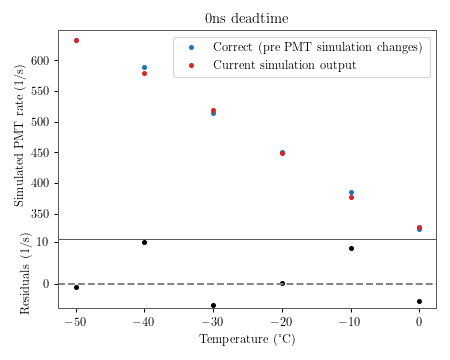

<IPython.core.display.Javascript object>


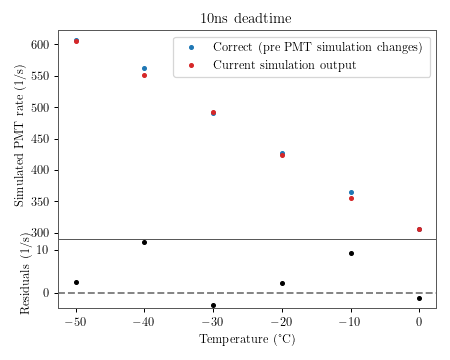

<IPython.core.display.Javascript object>


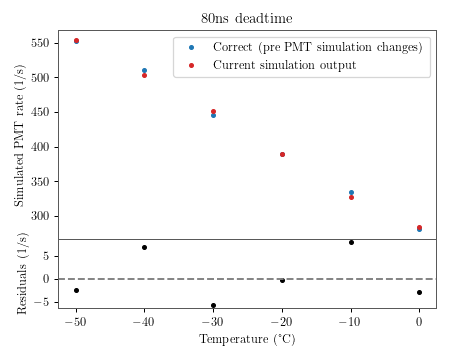

In [19]:
folder = 'data_check/'
folder = 'Aftercorrectionscheck_old/'
folder = 'Aftercorrectionscheck/'
simtemprange = np.arange(-50, 1, 10)

temps=[]
simrate_0ns=[]
simrate_10ns=[]
simrate_80ns=[]

for temp in simtemprange:
    #filename = f"{folder}FinalCheck_mDOM_60sWindow_{temp}C"
    filename = f"{folder}AftercorrectionsCheck_mDOM_{temp}C"
    try:
        settingsfile = f"{filename}_args.json"
        # Load JSON data directly from file
        with open(settingsfile, 'r') as file:
            data = json.load(file)

        num_events = data['numevents']
        time_window = data['time_window']
        duration=num_events*time_window

        eventid, time, PMT, energy, x, y, z, PE, TT, DP = np.genfromtxt(f"{filename}_hits.dat",unpack=1)#, dtype=np.longdouble)

        hits, deadhits, deadtime, alldts, lost, total = gimme(deadtime=0)
        print(f'T={temp}: \t Average PMT rate: {np.mean(hits):.2f} +- {np.std(hits):.2f}\t Target: {ExpectedPMTRate_0ns[ExpectedTemps==temp][0]}  Eaten by deadtime ({deadtime*10**9}ns): {sum(deadhits)/(sum(hits)+sum(deadhits))*100:.2f}%')
        simrate_0ns.append(np.mean(hits))
        
        hits, deadhits, deadtime, alldts, lost, total = gimme(deadtime=10e-9)
        print(f'T={temp}: \t Average PMT rate: {np.mean(hits):.2f} +- {np.std(hits):.2f}\t Target: {ExpectedPMTRate_10ns[ExpectedTemps==temp][0]}  Eaten by deadtime ({deadtime*10**9}ns): {sum(deadhits)/(sum(hits)+sum(deadhits))*100:.2f}%')
        simrate_10ns.append(np.mean(hits))
        
        hits, deadhits, deadtime, alldts, lost, total = gimme(deadtime=80e-9)
        print(f'T={temp}: \t Average PMT rate: {np.mean(hits):.2f} +- {np.std(hits):.2f}\t Target: {ExpectedPMTRate_80ns[ExpectedTemps==temp][0]}  Eaten by deadtime ({deadtime*10**9}ns): {sum(deadhits)/(sum(hits)+sum(deadhits))*100:.2f}%')
        simrate_80ns.append(np.mean(hits))
        print()
        
        temps.append(temp)
    except Exception as err:
        print(err)
        continue

plotit(ExpectedPMTRate_0ns, simrate_0ns, temps, 0)
plotit(ExpectedPMTRate_10ns, simrate_10ns, temps, 10)
plotit(ExpectedPMTRate_80ns, simrate_80ns, temps, 80)

### Aftercorrections?

In case there are deviations, do an aftercorrection to compensate. This can be caused by insufficient statistics (--time_window or -n too low) or that the yield correction was inaccurate. 

This was done iteratively to fine-tune so the calculation for the actual value is lost

<IPython.core.display.Javascript object>


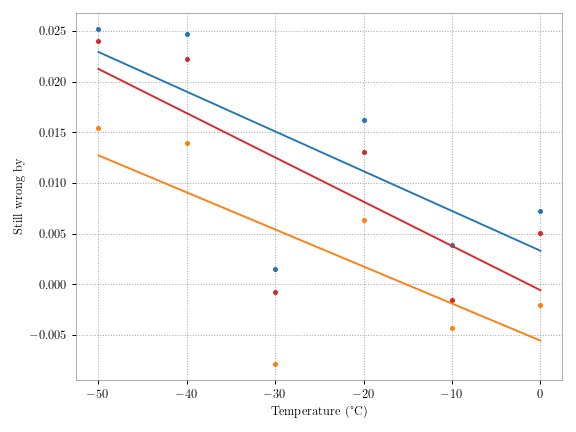

For 0ns: add this to your previous correction factors: -0.0001960528053519622 0.001660001200636054
For 10ns: add this to your previous correction factors: -0.00021822502684754053 -0.00028688645042462824
For 80ns: add this to your previous correction factors: -0.00018272679078035203 -0.0027745402412734377
Overall correction: [-0.000199   -0.00046714]
These should be your parameters: [4.30564873e-04 1.40205135e+00]


In [40]:

makeaplot(xlabel="Temperature (°C)",ylabel="Still wrong by")

factor_0ns=1-simrate_0ns/ExpectedPMTRate_0ns
plt.plot(temps,factor_0ns,'.',color='tab:blue')
popt_0ns, pcov_0ns = curve_fit(fitfkt, temps, factor_0ns)#, p0 = Initial)
error_0ns = np.sqrt(np.diag(pcov_0ns)) 
plt.plot(temps,fitfkt(np.array(temps),*popt_0ns),'tab:blue')
print("For 0ns: add this to your previous correction factors:", float(popt_0ns[0]/2),float(popt_0ns[1]/2))

factor_10ns=1-simrate_10ns/ExpectedPMTRate_10ns
plt.plot(temps,factor_10ns,'.',color='tab:red')
popt_10ns, pcov_10ns = curve_fit(fitfkt, temps, factor_10ns)#, p0 = Initial)
error_10ns = np.sqrt(np.diag(pcov_10ns)) 
plt.plot(temps,fitfkt(np.array(temps),*popt_10ns),'tab:red')
print("For 10ns: add this to your previous correction factors:", float(popt_10ns[0]/2),float(popt_10ns[1]/2))

factor_80ns=1-simrate_80ns/ExpectedPMTRate_80ns
plt.plot(temps,factor_80ns,'.',color='tab:orange')
popt_80ns, pcov_80ns = curve_fit(fitfkt, temps, factor_80ns)#, p0 = Initial)
error_80ns = np.sqrt(np.diag(pcov_80ns)) 
plt.plot(temps,fitfkt(np.array(temps),*popt_80ns),'tab:orange')
print("For 80ns: add this to your previous correction factors:", float(popt_80ns[0]/2),float(popt_80ns[1]/2))

finishplot(legend=False)

print("Overall correction:", (popt_0ns+popt_10ns+popt_80ns)/3/2)


#print("These should be your parameters:",popt_PMTcorr + (popt_0ns+popt_10ns+popt_80ns)/3/2)



In [7]:
fit_pmtcorr = [0.0009725,1.40]

## Compared to DVT measurement

mDOM DVT4, 80ns deadtime.

Fig 11.52 from https://www.uni-muenster.de/imperia/md/content/physik_kp/agkappes/abschlussarbeiten/doktorarbeiten/phd_thesis_unland.pdf

T=-40: 	 Average PMT rate: 503.11 +- 12.53	 Target: 529.84  Eaten by deadtime (80.0ns): 13.13%
T=-30: 	 Average PMT rate: 451.06 +- 12.42	 Target: 465.74  Eaten by deadtime (80.0ns): 13.08%
T=-20: 	 Average PMT rate: 389.51 +- 11.50	 Target: 409.61  Eaten by deadtime (80.0ns): 13.37%
T=-10: 	 Average PMT rate: 326.66 +- 10.16	 Target: 354.24  Eaten by deadtime (80.0ns): 13.52%


<IPython.core.display.Javascript object>


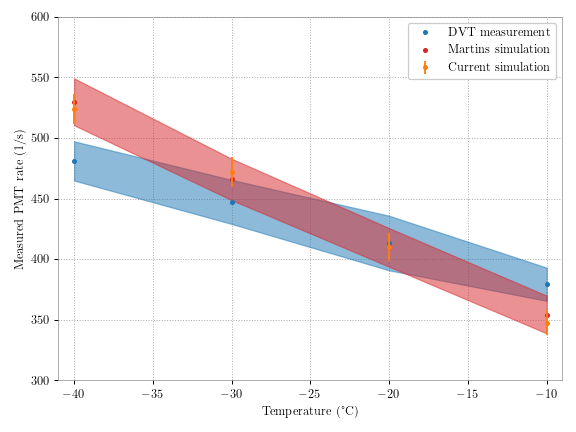

In [6]:
DVT_t = np.array([-40, -30, -20, -10])
DVT_rate = np.array([379.2264668367347, 413.2396212121212, 447.20470183486236, 481.04777353689565])
DVT_rate = DVT_rate[::-1]
DVT_rate_e = np.array([13.69407489097276, 22.5283261164992, 18.180432079315768, 16.186863982276176])
DVT_rate_e = DVT_rate_e[::-1]

MartinsSim_rate = np.array([529.84, 465.74, 409.61, 354.24]) #was plot to data...equal to ExpectedPMTRate_80ns+intrinsicPMTrate
helper = np.array([510.49, 448.67, 393.68, 338.69])
MartinsSim_rate_e = MartinsSim_rate - helper


#folder = 'data_check/'
folder = 'Aftercorrectionscheck/'
simtemprange = np.arange(-40, -9, 10)

AP2factor = 1#1.0565 #<- did Martin forget the AP factor in the plot?
intrinsicPMTrate = ufloat(35.2, 1.5)/1.7

temps=[]
simrate=[]
simrate_e=[]
for temp in simtemprange:
    #filename = f"{folder}FinalCheck_mDOM_60sWindow_{temp}C"
    filename = f"{folder}AftercorrectionsCheck_mDOM_{temp}C"

    try:
        settingsfile = f"{filename}_args.json"
        # Load JSON data directly from file
        with open(settingsfile, 'r') as file:
            data = json.load(file)

        num_events = data['numevents']
        time_window = data['time_window']
        duration=num_events*time_window

        eventid, time, PMT, energy, x, y, z, PE, TT, DP = np.genfromtxt(f"{filename}_hits.dat",unpack=1)#, dtype=np.longdouble)

        hits, deadhits, deadtime, alldts, lost, total = gimme(deadtime=80e-9)
        print(f'T={temp}: \t Average PMT rate: {np.mean(hits):.2f} +- {np.std(hits):.2f}\t Target: {MartinsSim_rate[DVT_t==temp][0]}  Eaten by deadtime ({deadtime*10**9}ns): {sum(deadhits)/(sum(hits)+sum(deadhits))*100:.2f}%')
        
        rate=ufloat(np.mean(hits),np.std(hits))
        rate = rate*AP2factor + intrinsicPMTrate
        simrate.append(rate.nominal_value)
        simrate_e.append(rate.std_dev)
        temps.append(temp)
    except Exception as err:
        print(err)
        continue
        

        
makeaplot(xlim=(-41,-9),ylim=(300,600),xlabel="Temperature (°C)",ylabel="Measured PMT rate (1/s)")
#plt.errorbar(DVT_t,DVT_rate,DVT_rate_e,fmt='.',color='tab:blue',label='DVT  measurement')
plt.plot(DVT_t,DVT_rate,'.',color='tab:blue',label='DVT  measurement')
plt.fill_between(DVT_t,y1=DVT_rate-DVT_rate_e, y2=DVT_rate+DVT_rate_e,alpha=0.5,color='tab:blue')

#plt.errorbar(DVT_t,MartinsSim_rate,MartinsSim_rate_e,fmt='.',color='tab:red',label='Martins simulation')
plt.plot(DVT_t,MartinsSim_rate,'.',color='tab:red',label='Martins simulation')
plt.fill_between(DVT_t,y1=MartinsSim_rate-MartinsSim_rate_e, y2=MartinsSim_rate+MartinsSim_rate_e,alpha=0.5,color='tab:red')


plt.errorbar(temps,simrate,simrate_e,fmt='.',color='tab:orange',label='Current simulation')

finishplot(filename='DVT_check')

# Check dT histograms

Compare to Figure 11.34 from https://www.uni-muenster.de/imperia/md/content/physik_kp/agkappes/abschlussarbeiten/doktorarbeiten/phd_thesis_unland.pdf

Just checking for 0°C for all individual PMTs with low statistics


<IPython.core.display.Javascript object>


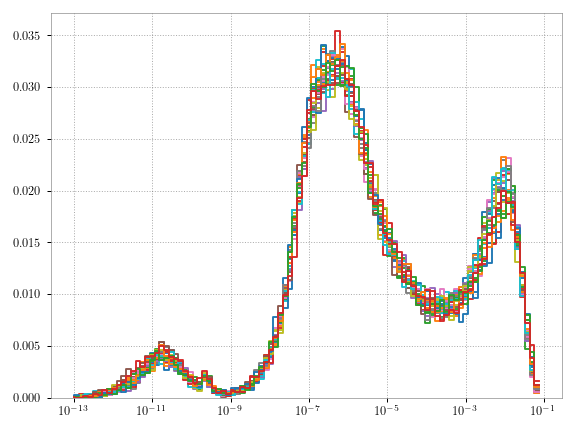

In [20]:
print(f"Just checking for {temp}°C for all individual PMTs with low statistics")
makeaplot()
for t in alldts:
    
    min_dt = 1e-13
    max_dt = 1e-1
    bins = np.logspace(np.log10(min_dt), np.log10(max_dt), num=100)   
    
    hist, bin_edges = np.histogram(t,bins=bins)
    hist = hist / np.sum(hist)
    
    
    #plt.hist(t,bins=bins,histtype='step')
    
    plt.step(bin_edges[:-1],hist)
    
plt.xscale('log')
plt.ylim(min_dt)
plt.xticks(np.logspace(-13,-1,7))
finishplot(legend=False)




# Export new scintillation file

In [32]:
import json

# Load JSON data from a file
json_file_path = 'G4Files/Scint_Vitrovex.dat'
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Modify the data. Correct alpha= alpha * PMT_simulation_correction(temperature). elec = alpha * elecfactor(temperature)
data['jYieldAlpha'] = [(fit_pmtcorr[0]*temp+fit_pmtcorr[1]) * alpha for alpha, temp in zip(data['jYieldAlpha'],data['jYieldAlphaTemperature'])]
data['jYieldElectron'] = [(fit_elec[0]*temp+fit_elec[1]) * alpha for alpha, temp in zip(data['jYieldAlpha'],data['jYieldAlphaTemperature'])]
data['jYieldElectronTemperature'] = [temp for temp in data['jYieldAlphaTemperature']]

# Write the modified data back to a file
output_file_path = 'Modified_Scint_Vitrovex.dat'  # You can use the same `json_file_path` to overwrite the original file
with open(output_file_path, 'w') as file:
    json.dump(data, file, indent=4)  # `indent=4` for pretty printing

print("JSON data has been successfully modified and written to:", output_file_path)

JSON data has been successfully modified and written to: Modified_Scint_Vitrovex.dat


# Verify Module rates

Data is not attached due to size. Each module (except for DOM, HQEDOM for which the Benthos glass has not been measured) was simulated for T=0° to -50°C.

LOMs just based on Vitrovex for testing

In [7]:
# Dictionary mappings
detector_names = {
    2: "mDOM",
    3: "DOM",
    4: "LOM16",
    5: "LOM18",
    6: "DEgg",
    7: "HQEDOM"
}

# Number of PMTs (placeholders or examples)
nrPMTs_values = {
    2: 24,
    3: 1,
    4: 16,
    5: 18,
    6: 2,
    7: 1
}

# AP2factor values 
AP2factors = {
    2: 1.0565,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1
}

# itrinsicPMTrate 
rate_errors = {
    2: 35.2,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0
}

# deadtime 
deadtime = {
    2: 10,
    3: 10,
    4: 10,
    5: 10,
    6: 10,
    7: 10
}

# Final dictionary assembly
detectors_info = {
    mod: {
        "name": detector_names[mod],
        "AP2factor": AP2factors[mod],
        "intrinsicPMTrate": rate_errors[mod],
        "nrPMTs": nrPMTs_values[mod],
        "deadtime": deadtime[mod]
    } for mod in detector_names.keys()
}

# Print out the structure
import pprint
pprint.pprint(detectors_info)

{2: {'AP2factor': 1.0565,
     'deadtime': 10,
     'intrinsicPMTrate': 35.2,
     'name': 'mDOM',
     'nrPMTs': 24},
 3: {'AP2factor': 1,
     'deadtime': 10,
     'intrinsicPMTrate': 0,
     'name': 'DOM',
     'nrPMTs': 1},
 4: {'AP2factor': 1,
     'deadtime': 10,
     'intrinsicPMTrate': 0,
     'name': 'LOM16',
     'nrPMTs': 16},
 5: {'AP2factor': 1,
     'deadtime': 10,
     'intrinsicPMTrate': 0,
     'name': 'LOM18',
     'nrPMTs': 18},
 6: {'AP2factor': 1,
     'deadtime': 10,
     'intrinsicPMTrate': 0,
     'name': 'DEgg',
     'nrPMTs': 2},
 7: {'AP2factor': 1,
     'deadtime': 10,
     'intrinsicPMTrate': 0,
     'name': 'HQEDOM',
     'nrPMTs': 1}}


mDOM with 10ns deadtime at T=-50: 	 Average PMT rate: 599.73 +- 13.97	 Eaten by deadtime 10.0ns: 3.92%
mDOM with 10ns deadtime at T=-40: 	 Average PMT rate: 557.30 +- 17.59	 Eaten by deadtime 10.0ns: 4.19%
mDOM with 10ns deadtime at T=-30: 	 Average PMT rate: 488.67 +- 16.07	 Eaten by deadtime 10.0ns: 4.33%
mDOM with 10ns deadtime at T=-20: 	 Average PMT rate: 426.71 +- 10.74	 Eaten by deadtime 10.0ns: 4.65%
mDOM with 10ns deadtime at T=-10: 	 Average PMT rate: 367.52 +- 10.21	 Eaten by deadtime 10.0ns: 5.09%
mDOM with 10ns deadtime at T=0: 	 Average PMT rate: 301.13 +- 5.91	 Eaten by deadtime 10.0ns: 5.76%


<IPython.core.display.Javascript object>


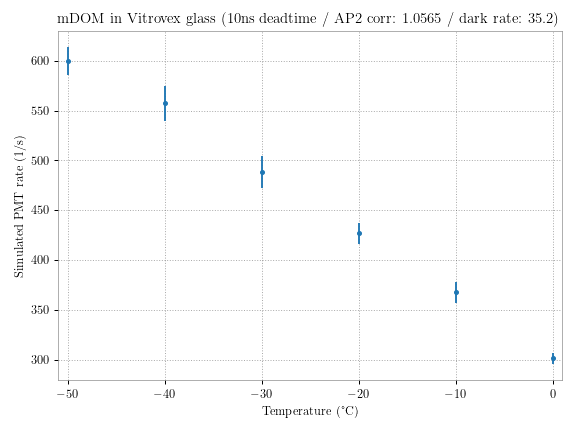

[Errno 2] No such file or directory: 'ThisWouldBeCommited_WithDegg_vitro/DOM_-50_args.json'
ThisWouldBeCommited_WithDegg_vitro/DOM_-40_hits.dat not found.
ThisWouldBeCommited_WithDegg_vitro/DOM_-30_hits.dat not found.
ThisWouldBeCommited_WithDegg_vitro/DOM_-20_hits.dat not found.
ThisWouldBeCommited_WithDegg_vitro/DOM_-10_hits.dat not found.
ThisWouldBeCommited_WithDegg_vitro/DOM_0_hits.dat not found.
LOM16 with 10ns deadtime at T=-50: 	 Average PMT rate: 952.67 +- 19.32	 Eaten by deadtime 10.0ns: 4.37%
LOM16 with 10ns deadtime at T=-40: 	 Average PMT rate: 741.94 +- 17.70	 Eaten by deadtime 10.0ns: 3.92%
LOM16 with 10ns deadtime at T=-30: 	 Average PMT rate: 627.28 +- 20.17	 Eaten by deadtime 10.0ns: 4.17%
LOM16 with 10ns deadtime at T=-20: 	 Average PMT rate: 553.49 +- 15.74	 Eaten by deadtime 10.0ns: 4.47%
LOM16 with 10ns deadtime at T=-10: 	 Average PMT rate: 621.06 +- 13.10	 Eaten by deadtime 10.0ns: 5.82%
LOM16 with 10ns deadtime at T=0: 	 Average PMT rate: 405.59 +- 10.51	 Eaten

<IPython.core.display.Javascript object>


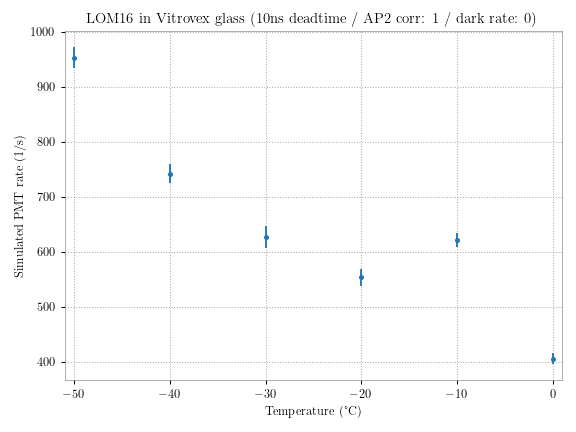

LOM18 with 10ns deadtime at T=-50: 	 Average PMT rate: 1013.79 +- 47.41	 Eaten by deadtime 10.0ns: 3.67%
LOM18 with 10ns deadtime at T=-40: 	 Average PMT rate: 948.46 +- 46.26	 Eaten by deadtime 10.0ns: 3.90%
LOM18 with 10ns deadtime at T=-30: 	 Average PMT rate: 824.16 +- 41.78	 Eaten by deadtime 10.0ns: 4.10%
ThisWouldBeCommited_WithDegg_vitro/LOM18_-20_hits.dat not found.
LOM18 with 10ns deadtime at T=-10: 	 Average PMT rate: 612.59 +- 25.87	 Eaten by deadtime 10.0ns: 4.70%
LOM18 with 10ns deadtime at T=0: 	 Average PMT rate: 509.79 +- 26.03	 Eaten by deadtime 10.0ns: 5.25%


<IPython.core.display.Javascript object>


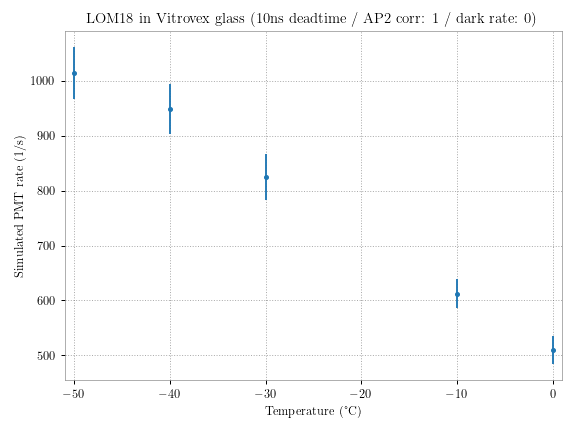

DEgg with 10ns deadtime at T=-50: 	 Average PMT rate: 5263.89 +- 21.32	 Eaten by deadtime 10.0ns: 5.27%
DEgg with 10ns deadtime at T=-40: 	 Average PMT rate: 4946.67 +- 75.22	 Eaten by deadtime 10.0ns: 5.54%
DEgg with 10ns deadtime at T=-30: 	 Average PMT rate: 4293.02 +- 68.11	 Eaten by deadtime 10.0ns: 5.72%
DEgg with 10ns deadtime at T=-20: 	 Average PMT rate: 3719.18 +- 21.90	 Eaten by deadtime 10.0ns: 6.06%
DEgg with 10ns deadtime at T=-10: 	 Average PMT rate: 3164.99 +- 62.71	 Eaten by deadtime 10.0ns: 6.35%
DEgg with 10ns deadtime at T=0: 	 Average PMT rate: 2652.60 +- 8.55	 Eaten by deadtime 10.0ns: 6.93%


<IPython.core.display.Javascript object>


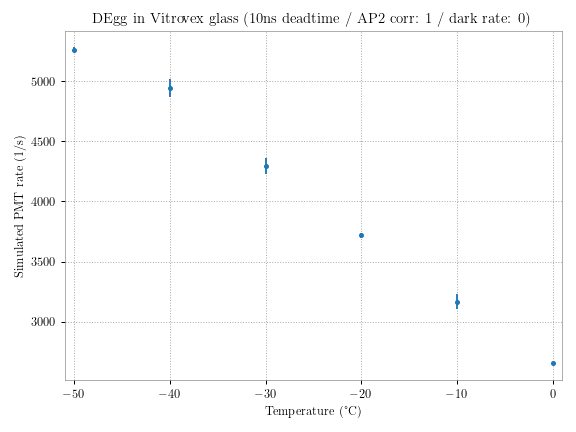

ThisWouldBeCommited_WithDegg_vitro/HQEDOM_-50_hits.dat not found.
ThisWouldBeCommited_WithDegg_vitro/HQEDOM_-40_hits.dat not found.
ThisWouldBeCommited_WithDegg_vitro/HQEDOM_-30_hits.dat not found.
[Errno 2] No such file or directory: 'ThisWouldBeCommited_WithDegg_vitro/HQEDOM_-20_args.json'
ThisWouldBeCommited_WithDegg_vitro/HQEDOM_-10_hits.dat not found.
ThisWouldBeCommited_WithDegg_vitro/HQEDOM_0_hits.dat not found.


In [8]:
folder = 'ThisWouldBeCommited_WithDegg_vitro/'
simtemprange = np.arange(-50, 1, 10)
deadtime = 10

for module_number, module_info in detectors_info.items():
    temps=[]
    simrate=[]
    simrate_e=[]
    plot=False
    for temp in simtemprange:
        filename = f"{folder}{module_info['name']}_{temp}"
        deadtime = module_info['deadtime']

        try:
            settingsfile = f"{filename}_args.json"
            # Load JSON data directly from file
            with open(settingsfile, 'r') as file:
                data = json.load(file)

            num_events = data['numevents']
            time_window = data['time_window']
            duration=num_events*time_window

            eventid, time, PMT, energy, x, y, z, PE, TT, DP = np.genfromtxt(f"{filename}_hits.dat",unpack=1)#, dtype=np.longdouble)

            hits, deadhits, deadtime, alldts, lost, total = gimme(deadtime=deadtime*1e-9)
            print(f"{module_info['name']} with {module_info['deadtime']}ns deadtime at T={temp}: \t Average PMT rate: {np.mean(hits):.2f} +- {np.std(hits):.2f}\t Eaten by deadtime {deadtime*10**9}ns: {sum(deadhits)/(sum(hits)+sum(deadhits))*100:.2f}%")

            #rate=ufloat(np.mean(hits),np.std(hits))
            #rate = rate*AP2factor + intrinsicPMTrate
            #simrate.append(rate.nominal_value)
            #simrate_e.append(rate.std_dev)
            simrate.append(np.mean(hits))
            simrate_e.append(np.std(hits))
            temps.append(temp)
            plot=True
        except Exception as err:
            print(err)
            continue
        
    if plot:
        makeaplot(xlim=(-51,1),xlabel="Temperature (°C)",ylabel="Simulated PMT rate (1/s)")
        plt.title(f"{module_info['name']} in Vitrovex glass ({module_info['deadtime']}ns deadtime / AP2 corr: {module_info['AP2factor']} / dark rate: {module_info['intrinsicPMTrate']})")
        plt.errorbar(temps, simrate, simrate_e, fmt='.', color='tab:blue')      
        finishplot(legend=False) 